# Basic Structure Similarity Analysis

This basic example will illustrate how to use Melodia to compare structural similarities between two proteins. Curvature and torsion are very sensitive to small changes in the backbone geometry and are also rotational invariant.

In [1]:
import dill
import warnings

import pandas as pd
import melodia as mel
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from math import sqrt
from sklearn.preprocessing import StandardScaler
from Bio.PDB.PDBExceptions import PDBConstructionWarning

warnings.filterwarnings("ignore", category=PDBConstructionWarning)

## Load data

For this example, we will load two proteins from the **Elicitin family**. They are small and exhibit very high similarity in their **chain A**.

In [2]:
df1 = mel.geometry_from_structure_file('1lri.pdb')
df1

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,1LRI,A,1,THR,0.523924,-0.118010,8.242813,-0.059194,0.000000,168.031125
1,1,0,1LRI,A,2,ALA,0.523924,-0.118010,7.896833,-0.059194,-75.363050,136.221155
2,2,0,1LRI,A,3,CYS,0.670033,-0.169718,7.896704,-0.059194,-60.494993,141.165783
3,3,0,1LRI,A,4,THR,0.569898,-0.180485,7.938670,-0.066212,-79.634848,173.203256
4,4,0,1LRI,A,5,ALA,0.697956,-0.010887,8.467120,0.010872,-63.077486,-37.574039
...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,0,1LRI,A,94,LYS,0.364686,0.162909,8.708571,0.226324,-59.899002,-45.781917
94,94,0,1LRI,A,95,CYS,0.327426,0.175977,8.718145,0.228522,-66.697245,-30.171642
95,95,0,1LRI,A,96,SER,0.436546,0.158725,8.642379,0.216261,-72.147382,-21.114371
96,96,0,1LRI,A,97,SER,0.496380,0.172699,8.514152,0.216261,-89.377454,0.000000


In [3]:
df2 = mel.geometry_from_structure_file('1ljp.pdb')
df2

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,1LJP,A,1,THR,0.475242,-0.125397,8.238142,-0.062727,0.000000,123.434247
1,1,0,1LJP,A,2,ALA,0.475242,-0.125397,7.895721,-0.062727,-52.966483,142.570656
2,2,0,1LJP,A,3,CYS,0.577759,-0.180926,7.936894,-0.062727,-61.699471,142.615040
3,3,0,1LJP,A,4,THR,0.524319,-0.185755,7.971694,-0.068045,-77.004092,174.286670
4,4,0,1LJP,A,5,ALA,0.756870,-0.010564,8.509298,0.015778,-60.909800,-42.817054
...,...,...,...,...,...,...,...,...,...,...,...,...
191,93,0,1LJP,B,94,LYS,0.375810,0.160864,8.720161,0.230690,-57.620473,-46.106610
192,94,0,1LJP,B,95,CYS,0.320742,0.178251,8.722546,0.222234,-58.503926,-48.355355
193,95,0,1LJP,B,96,ALA,0.424601,0.156529,8.592585,0.221073,-59.100665,-27.127038
194,96,0,1LJP,B,97,SER,0.554350,0.157387,8.531393,0.221073,-86.496455,0.000000


***
The following figure shows the sequence alignment for the chains A in the loaded structures. The alignment is colour-coded using the **JOY annotation**.
***

![elicitin](elicitin.png)

<table>
    <tr>
        <td  style="width:40%"><img src="joy.png" alt="Drawing"/></td>
        <td>Mizuguchi, K., Deane, C.M., Blundell, T.L., Johnson,M.S. and Overington, J.P. (1998) JOY: protein sequence-structure representation and analysis. Bioinformatics 14:617-623</td>   
    </tr> 
</table>

## Select relevant data
In the following steps, we select only the chains A and join the DataFrames. We drop some columns as we will conduct just a curvature and torsion similarity analysis. .

In [4]:
df1a = df1.loc[df1['chain'] == 'A'].copy()
df1a.drop(['id', 'model', 'chain', 'arc_length', 'writhing','phi', 'psi'], axis=1, inplace=True)
df1a

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.523924,-0.118010
1,1LRI,2,ALA,0.523924,-0.118010
2,1LRI,3,CYS,0.670033,-0.169718
3,1LRI,4,THR,0.569898,-0.180485
4,1LRI,5,ALA,0.697956,-0.010887
...,...,...,...,...,...
93,1LRI,94,LYS,0.364686,0.162909
94,1LRI,95,CYS,0.327426,0.175977
95,1LRI,96,SER,0.436546,0.158725
96,1LRI,97,SER,0.496380,0.172699


In [5]:
df2a = df2.loc[df2['chain'] == 'A'].copy()
df2a.drop(['id', 'model', 'chain', 'arc_length', 'writhing','phi', 'psi'], axis=1, inplace=True)
df2a

,code,order,name,curvature,torsion
0,1LJP,1,THR,0.475242,-0.125397
1,1LJP,2,ALA,0.475242,-0.125397
2,1LJP,3,CYS,0.577759,-0.180926
3,1LJP,4,THR,0.524319,-0.185755
4,1LJP,5,ALA,0.756870,-0.010564
...,...,...,...,...,...
93,1LJP,94,LYS,0.370523,0.165487
94,1LJP,95,CYS,0.328164,0.180254
95,1LJP,96,ALA,0.417953,0.155861
96,1LJP,97,SER,0.552575,0.162292


In [6]:
df = pd.concat([df1a, df2a], ignore_index=True)
df

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.523924,-0.118010
1,1LRI,2,ALA,0.523924,-0.118010
2,1LRI,3,CYS,0.670033,-0.169718
3,1LRI,4,THR,0.569898,-0.180485
4,1LRI,5,ALA,0.697956,-0.010887
...,...,...,...,...,...
191,1LJP,94,LYS,0.370523,0.165487
192,1LJP,95,CYS,0.328164,0.180254
193,1LJP,96,ALA,0.417953,0.155861
194,1LJP,97,SER,0.552575,0.162292


## Data preprocessing

In [7]:
# Define the autoscaler from scikit-learn
autoscaler = StandardScaler()

# Define features for scaling
features = ['curvature', 'torsion']

# Scale the DataFrame
dfsd = df.copy()
dfsd[features] = autoscaler.fit_transform(dfsd[features])

dfsd

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.774836,-0.592149
1,1LRI,2,ALA,0.774836,-0.592149
2,1LRI,3,CYS,1.676109,-0.796439
3,1LRI,4,THR,1.058428,-0.838978
4,1LRI,5,ALA,1.848348,-0.168918
...,...,...,...,...,...
191,1LJP,94,LYS,-0.171415,0.527915
192,1LJP,95,CYS,-0.432702,0.586259
193,1LJP,96,ALA,0.121159,0.489885
194,1LJP,97,SER,0.951567,0.515290


## Plot data for analysis
The following figures show the curvature and torsion data for the selected chains. Despite the highly conserved sequences, the structures show distinct geometric behaviour in diverse points. 
**The curvature and torsion values are sensitive enough to contrast tiny but fundamental changes in the protein's geometry that other measures, like RMSD, cannot do.**


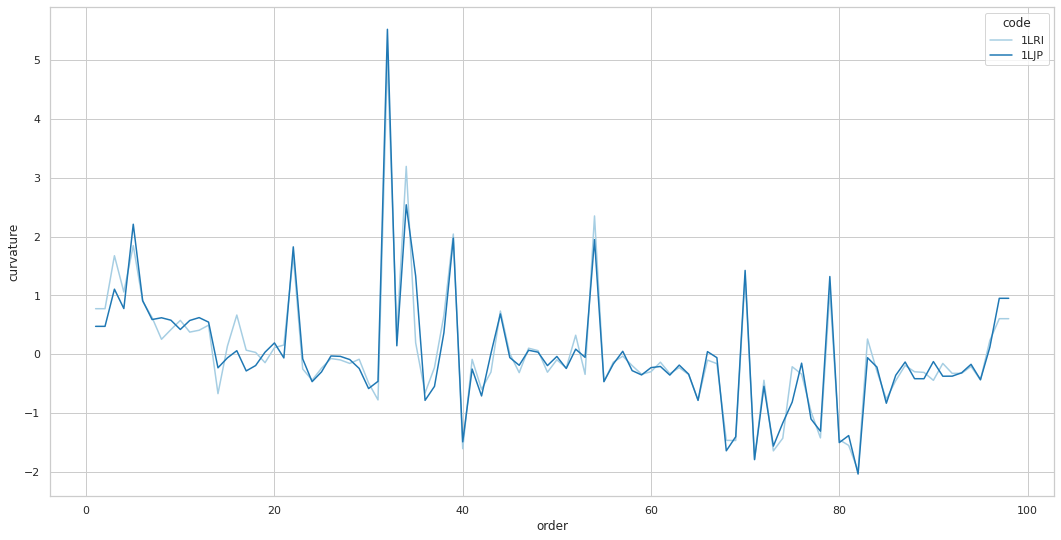

In [16]:
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x="order", y="curvature", hue="code", data=dfsd);

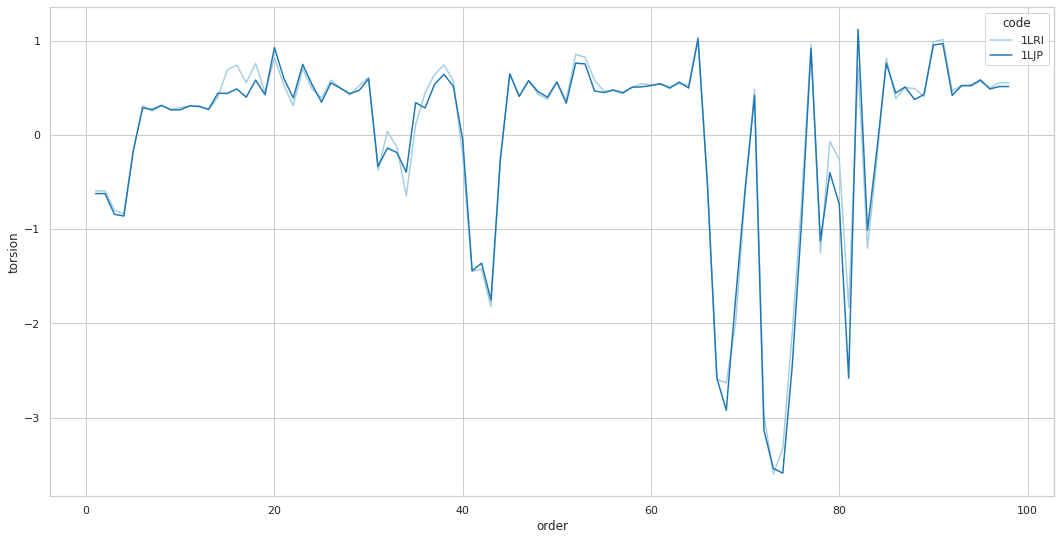

In [9]:
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x='order', y='torsion', hue='code', data=dfsd);

## Curvature and Torsion metric
We can also use Pandas' functions to quickly create a DataFrame with the Euclidian distance between **curvature and torsion**. We can employ the Euclidian distance as a measure of local geometric dissimilarity. 



In [17]:
# Merge the two chains using the proteins code as suffixes
dft = pd.merge(df1a, df2a, how='left', suffixes=['_1LRI', '_1LJP'], on='order')
dft.drop(['code_1LRI', 'code_1LJP'], axis=1, inplace=True)
dft

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP
0,1,THR,0.523924,-0.118010,THR,0.475242,-0.125397
1,2,ALA,0.523924,-0.118010,ALA,0.475242,-0.125397
2,3,CYS,0.670033,-0.169718,CYS,0.577759,-0.180926
3,4,THR,0.569898,-0.180485,THR,0.524319,-0.185755
4,5,ALA,0.697956,-0.010887,ALA,0.756870,-0.010564
...,...,...,...,...,...,...,...
93,94,LYS,0.364686,0.162909,LYS,0.370523,0.165487
94,95,CYS,0.327426,0.175977,CYS,0.328164,0.180254
95,96,SER,0.436546,0.158725,ALA,0.417953,0.155861
96,97,SER,0.496380,0.172699,SER,0.552575,0.162292


In [18]:
# Define features for scaling
features = ['curvature_1LRI', 'torsion_1LRI', 'curvature_1LJP', 'torsion_1LJP']

# Scale the DataFrame
dftsd = dft.copy()
dftsd[features] = autoscaler.fit_transform(dftsd[features])
dftsd

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP
0,1,THR,0.776050,-0.617255,THR,0.474192,-0.596840
1,2,ALA,0.776050,-0.617255,ALA,0.474192,-0.596840
2,3,CYS,1.679893,-0.824855,CYS,1.104779,-0.812889
3,4,THR,1.060450,-0.868082,THR,0.776066,-0.831676
4,5,ALA,1.852623,-0.187169,ALA,2.206497,-0.150054
...,...,...,...,...,...,...,...
93,94,LYS,-0.209008,0.510600,LYS,-0.169940,0.534912
94,95,CYS,-0.439502,0.563067,CYS,-0.430488,0.592367
95,96,SER,0.235523,0.493802,ALA,0.121807,0.497461
96,97,SER,0.605659,0.549907,SER,0.949868,0.522479


In [19]:
# Define the Euclidian distance between the two proteins
def dist(row):
    d = (row['curvature_1LRI'] - row['curvature_1LJP'])**2 + (row['torsion_1LRI'] - row['torsion_1LJP'])**2
    return sqrt(d)

# Create new columns with the Euclidian distance
dftsd['dist'] = dftsd.apply(dist, axis=1)
dftsd

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP,dist
0,1,THR,0.776050,-0.617255,THR,0.474192,-0.596840,0.302547
1,2,ALA,0.776050,-0.617255,ALA,0.474192,-0.596840,0.302547
2,3,CYS,1.679893,-0.824855,CYS,1.104779,-0.812889,0.575238
3,4,THR,1.060450,-0.868082,THR,0.776066,-0.831676,0.286705
4,5,ALA,1.852623,-0.187169,ALA,2.206497,-0.150054,0.355815
...,...,...,...,...,...,...,...,...
93,94,LYS,-0.209008,0.510600,LYS,-0.169940,0.534912,0.046015
94,95,CYS,-0.439502,0.563067,CYS,-0.430488,0.592367,0.030656
95,96,SER,0.235523,0.493802,ALA,0.121807,0.497461,0.113775
96,97,SER,0.605659,0.549907,SER,0.949868,0.522479,0.345299


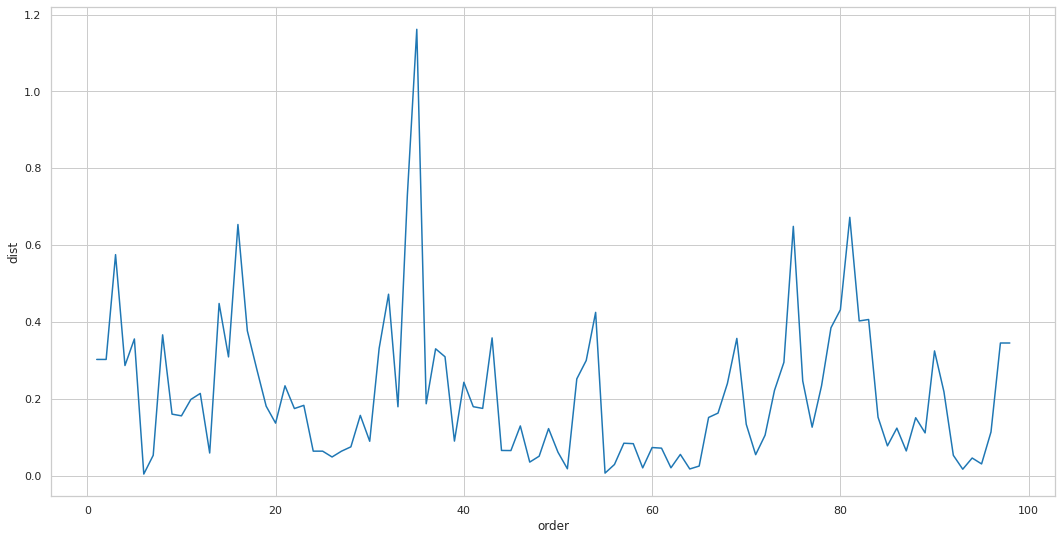

In [21]:
# Plot the Euclidian distance
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='tab10')
sns.lineplot(x='order', y='dist', data=dftsd);

## Helix analysis

Let us select only the first 25 residues covering the helix.

In [14]:
block = dfsd[dfsd['order'] <= 25]

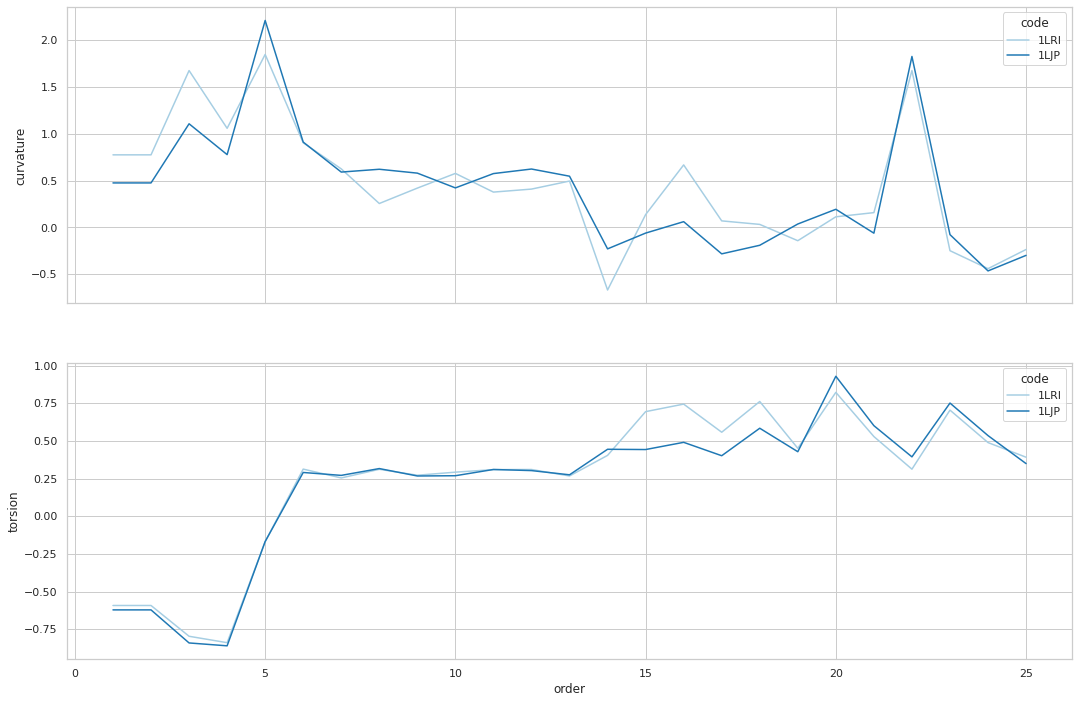

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18.0, 12.0))
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x="order", y="curvature", hue="code", data=block, ax=axes[0])
sns.lineplot(x="order", y="torsion", hue="code", data=block, ax=axes[1]);

<table>
    <tr>
        <td style="width:50%"><img src="elicitin_stru.png" alt="Drawing"/></td>
        <td><img src="elicitin_helix.png" alt="Drawing"/></td>   
    </tr> 
    <tr>
        <td>1LRI in ligth blue and 1LJ in blue.</td>
        <td>Residues from number 6 to number 25 coloured by torsion.</td>
</table>



***
Observing the plots, we see a significant change in the curvature and torsion values after residue 14. It is due to the geometric changes from an **alpha-helix to a 3-10-helix**, as we can verify in the annotated alignment.
***